In [3]:
!pip install --upgrade fsspec datasets transformers
!pip install huggingface_hub[hf_xet]
!pip install transformers
!pip cache purge

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 125.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.3
    Uninstalling transformers-4.52.3:
      Successfully uninstalled transformers-4.52.3
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Lin

In [7]:
import torch
from torch.optim import AdamW
from transformers import PreTrainedModel, BertModel, BertConfig, AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from datasets import load_dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm.auto import tqdm
import os
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm import tqdm
import copy

# Modello Actor-Critic basato su BERT
class ActorCriticBERT(PreTrainedModel):
    config_class = BertConfig

    def __init__(self, config, num_labels):
        super().__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config) # Modello BERT base

        # Dropout comune
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        # Testa dell'Attore (Policy)
        self.policy_head = nn.Linear(config.hidden_size, num_labels)

        # Testa del Critico (Value function)
        self.value_head = nn.Linear(config.hidden_size, 1)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True
        )

        # Usiamo l'output [CLS] token (o pooler_output)
        # last_hidden_state[:, 0] è spesso preferito a pooler_output per fine-tuning
        sequence_output = outputs.last_hidden_state
        pooled_output = sequence_output[:, 0] # Output del token [CLS]

        pooled_output = self.dropout(pooled_output)

        logits = self.policy_head(pooled_output)  # Logits per l'attore
        value = self.value_head(pooled_output)   # Stima del valore per il critico

        return {"logits": logits, "value": value}

# Funzione di tokenizzazione
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

# Funzione di computazione delle metrice
def compute_metrics(pred_dict):
    labels = pred_dict["label_ids"]
    preds = pred_dict["predictions"]
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Classe per gestire il training e l'early stopping
class SentimentTrainer:
    def __init__(self, model, optimizer, train_dataloader, eval_dataloader, tokenizer, device, patience=3, save_frequency=1, output_dir="./sentiment_checkpoints"):
        self.model = model
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        self.eval_dataloader = eval_dataloader
        self.tokenizer = tokenizer
        self.device = device
        self.patience = patience
        self.save_frequency = save_frequency
        self.output_dir = output_dir
        self.best_val_loss = float('inf')
        self.counter = 0
        self.best_model = None

        # Aggiungiamo queste liste per tracciare le metriche
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_metrics_history = []
        self.val_metrics_history = []

        os.makedirs(self.output_dir, exist_ok=True)
        shutil.rmtree(self.output_dir, ignore_errors=True)
        os.makedirs(self.output_dir, exist_ok=True)

    def save_checkpoint(self, epoch, val_loss):
        checkpoint_path = os.path.join(self.output_dir, f"checkpoint_epoch_{epoch}_loss_{val_loss:.4f}.pt")
        torch.save(self.model.state_dict(), checkpoint_path)
        print(f"Checkpoint salvato a {checkpoint_path}")

    def load_checkpoint(self, path):
        self.model.load_state_dict(torch.load(path, map_location=self.device))
        print(f"Modello caricato da {path}")

class RLFeedbackTrainer:
    def __init__(self, supervised_model, train_dataloader, tokenizer, device, rl_hparams=None):
        self.tokenizer = tokenizer
        self.device = device
        self.train_dataloader = train_dataloader

        self.hparams = {
            "lr": 5e-6,
            "kl_beta": 0.05, # Ridotto per iniziare con cautela
            "ppo_epsilon": 0.2,
            "vf_coef": 0.5,
            "ent_coef": 0.01,
            "gamma": 0.99, # Utile se si considerassero traiettorie più lunghe, per classificazione 1-step spesso non critico
            "ppo_epochs_per_batch": 3, # Quante volte ottimizzare su ogni batch raccolto
        }
        if rl_hparams:
            self.hparams.update(rl_hparams)

        # 1. Crea il modello Actor-Critic
        # Usiamo la configurazione del modello supervisionato per inizializzare ActorCriticBERT
        self.actor_critic_model = ActorCriticBERT(config=supervised_model.config, num_labels=supervised_model.config.num_labels)

        # Carica i pesi dal modello supervisionato (principalmente per il corpo BERT e la testa di classificazione se i nomi corrispondono)
        # La testa 'policy_head' in ActorCriticBERT dovrebbe idealmente avere lo stesso nome/struttura
        # della testa di classificazione del 'supervised_model' per un caricamento diretto dei pesi.
        # Se 'supervised_model' è AutoModelForSequenceClassification, la sua testa di classificazione è 'classifier'.
        # Adattiamo il caricamento:
        supervised_state_dict = supervised_model.state_dict()
        actor_critic_state_dict = self.actor_critic_model.state_dict()

        # Carica i pesi del BERT
        for name, param in supervised_state_dict.items():
            if name.startswith("bert."): # Carica tutti i pesi del corpo di BERT
                if name in actor_critic_state_dict and actor_critic_state_dict[name].shape == param.shape:
                    actor_critic_state_dict[name].copy_(param)
                else:
                    print(f"Skipping {name} from supervised_model due to mismatch or absence in actor_critic_model.")

        # Se supervised_model.classifier esiste e actor_critic_model.policy_head esiste
        if "classifier.weight" in supervised_state_dict and "policy_head.weight" in actor_critic_state_dict:
            actor_critic_state_dict["policy_head.weight"].copy_(supervised_state_dict["classifier.weight"])
            actor_critic_state_dict["policy_head.bias"].copy_(supervised_state_dict["classifier.bias"])
        else:
            print("Warning: Classifier weights not loaded into policy_head. Ensure names match or initialize policy_head appropriately.")

        self.actor_critic_model.load_state_dict(actor_critic_state_dict, strict=False) # strict=False per la value_head non inizializzata
        self.actor_critic_model.to(self.device)
        print("Actor-Critic model created and weights loaded from supervised model.")

        # 2. Crea il modello di riferimento per la KL divergence (stato del modello post-supervisione)
        self.reference_model = ActorCriticBERT(config=supervised_model.config, num_labels=supervised_model.config.num_labels)
        self.reference_model.load_state_dict(self.actor_critic_model.state_dict()) # Copia lo stato iniziale (post-supervisione)
        self.reference_model.to(self.device)
        self.reference_model.eval()
        print("Reference model for KL divergence created.")

        # 3. Ottimizzatore per il modello Actor-Critic
        self.optimizer = AdamW(self.actor_critic_model.parameters(), lr=self.hparams["lr"])

    def compute_rewards(self, predicted_actions, true_labels, action_probs, target_label_for_reward=None):
        """
        Calcola le ricompense.
        predicted_actions: azioni (classi) predette dal modello.
        true_labels: etichette vere.
        action_probs: probabilità delle azioni.
        target_label_for_reward: se specificato, la ricompensa è +1 se predicted_action è questa label, altrimenti 0 o -1.
                                 Utile per guidare il modello verso una classe specifica se necessario.
        """
        if target_label_for_reward is not None:
            # Esempio: ricompensa +1 se predice la classe target, -0.1 altrimenti
            # Questo è un esempio di come si potrebbe personalizzare la reward per obiettivi specifici
            rewards = torch.where(predicted_actions == target_label_for_reward,
                                  torch.tensor(1.0, device=self.device),
                                  torch.tensor(-0.1, device=self.device))
        else:
            # Ricompensa standard: +1 per corretto, 0 o -1 per incorretto
            rewards = (predicted_actions == true_labels).float()
            # Si potrebbe usare +1/-1 per incoraggiare più fortemente la correttezza:
            # rewards = torch.where(predicted_actions == true_labels,
            #                       torch.tensor(1.0, device=self.device),
            #                       torch.tensor(-1.0, device=self.device))
        return rewards

    def rl_training_phase(self, num_epochs):
        print(f"Starting Reinforcement Learning Phase for {num_epochs} epochs...")
        for epoch in range(num_epochs):
            self.actor_critic_model.train()
            total_rl_loss = 0
            total_actor_loss = 0
            total_critic_loss = 0
            total_entropy = 0
            total_kl_div = 0

            progress_bar = tqdm(self.train_dataloader, desc=f"RL Epoch {epoch+1}/{num_epochs}")
            for batch_idx, batch in enumerate(progress_bar):
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                true_labels = batch["labels"].to(self.device)

                # --- Raccolta dati con la policy corrente (per PPO) ---
                # Questi valori sono calcolati una volta per batch e usati come "old" policy
                with torch.no_grad():
                    outputs_old = self.actor_critic_model(input_ids=input_ids, attention_mask=attention_mask)
                    logits_old = outputs_old["logits"]
                    values_old = outputs_old["value"].squeeze(-1) # Rimuovi l'ultima dimensione

                    action_probs_old = F.softmax(logits_old, dim=-1)
                    distribution_old = Categorical(action_probs_old)
                    # Campiona azioni per l'esplorazione
                    actions_sampled = distribution_old.sample()
                    log_probs_old = distribution_old.log_prob(actions_sampled)

                # Calcola le ricompense basate sulle azioni campionate
                # Qui si potrebbe passare un target_label_for_reward se l'obiettivo è specifico
                rewards = self.compute_rewards(actions_sampled, true_labels, action_probs_old)

                # Calcola gli advantage
                # Per la classificazione (task a 1 step), GAE si semplifica: Advantage = Reward - Value
                # Non c'è V(s_t+1) perché ogni classificazione è un episodio terminale.
                advantages = rewards - values_old
                # Normalizza gli advantage (opzionale ma spesso utile)
                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

                # Target per la value function (per il critic loss) sono le ricompense ottenute
                value_targets = rewards

                # --- Loop di ottimizzazione PPO (su questo batch) ---
                for _ in range(self.hparams["ppo_epochs_per_batch"]):
                    outputs_new = self.actor_critic_model(input_ids=input_ids, attention_mask=attention_mask)
                    logits_new = outputs_new["logits"]
                    values_new = outputs_new["value"].squeeze(-1)

                    action_probs_new = F.softmax(logits_new, dim=-1)
                    distribution_new = Categorical(action_probs_new)

                    # Log probabilità delle azioni campionate *sotto la nuova policy*
                    log_probs_new = distribution_new.log_prob(actions_sampled)

                    # Rapporto tra nuova e vecchia policy (per PPO)
                    ratio = torch.exp(log_probs_new - log_probs_old.detach()) # log_probs_old è costante qui

                    # Actor Loss (PPO Clipped Surrogate Objective)
                    surr1 = ratio * advantages.detach() # advantages sono costanti qui
                    surr2 = torch.clamp(ratio, 1.0 - self.hparams["ppo_epsilon"], 1.0 + self.hparams["ppo_epsilon"]) * advantages.detach()
                    actor_loss = -torch.min(surr1, surr2).mean()

                    # Critic Loss (Mean Squared Error)
                    critic_loss = F.mse_loss(values_new, value_targets.detach()) * self.hparams["vf_coef"]

                    # Entropia (per incoraggiare l'esplorazione)
                    entropy_bonus = distribution_new.entropy().mean() * self.hparams["ent_coef"]

                    # KL Divergence Loss (con il modello di riferimento)
                    with torch.no_grad():
                        ref_outputs = self.reference_model(input_ids=input_ids, attention_mask=attention_mask)
                        ref_logits = ref_outputs["logits"]

                    # Usiamo log_softmax per l'input della KL divergence e softmax per il target
                    current_log_probs_dist = F.log_softmax(logits_new, dim=-1)
                    ref_probs_dist = F.softmax(ref_logits, dim=-1)

                    kl_div = F.kl_div(current_log_probs_dist, ref_probs_dist, reduction='batchmean', log_target=False)
                    kl_loss = kl_div * self.hparams["kl_beta"]

                    # Loss totale
                    # Vogliamo massimizzare l'entropia, quindi la sottraiamo (se l'ottimizzatore minimizza)
                    loss = actor_loss + critic_loss - entropy_bonus + kl_loss

                    self.optimizer.zero_grad()
                    loss.backward()
                    # Gradient clipping (opzionale ma consigliato)
                    # torch.nn.utils.clip_grad_norm_(self.actor_critic_model.parameters(), max_norm=1.0)
                    self.optimizer.step()

                    total_rl_loss += loss.item()
                    total_actor_loss += actor_loss.item()
                    total_critic_loss += critic_loss.item()
                    total_entropy += entropy_bonus.item()
                    total_kl_div += kl_loss.item()

            avg_rl_loss = total_rl_loss / (len(self.train_dataloader) * self.hparams["ppo_epochs_per_batch"])
            avg_actor_loss = total_actor_loss / (len(self.train_dataloader) * self.hparams["ppo_epochs_per_batch"])
            avg_critic_loss = total_critic_loss / (len(self.train_dataloader) * self.hparams["ppo_epochs_per_batch"])
            avg_entropy = total_entropy / (len(self.train_dataloader) * self.hparams["ppo_epochs_per_batch"])
            avg_kl_div = total_kl_div / (len(self.train_dataloader) * self.hparams["ppo_epochs_per_batch"])

            print(f"Epoch {epoch+1} RL Stats: Avg Total Loss: {avg_rl_loss:.4f}, "
                  f"Actor: {avg_actor_loss:.4f}, Critic: {avg_critic_loss:.4f}, "
                  f"Entropy: {avg_entropy:.4f}, KL Div: {avg_kl_div:.4f}")

        # Dopo il training RL, il modello principale da usare per la valutazione è self.actor_critic_model
        # Potresti voler restituire questo modello o aggiornare il modello originale nel tuo script principale.
        # Per ora, facciamo in modo che lo script principale possa accedere a questo modello.
        print("Reinforcement Learning Phase completed.")
#Modifica al dataset per nascondere le etichette
class HiddenLabelsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            "input_ids": item["input_ids"],
            "attention_mask": item["attention_mask"],
            "hidden_labels": item["labels"]  # Etichette nascoste
        }

    def __len__(self):
        return len(self.dataset)


# Configurazione del device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Carica il dataset
dataset = load_dataset("dair-ai/emotion")
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]
test_dataset = dataset["test"]


Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [8]:

# Tokenizer e modello
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)
model.to(device)

# Applica la tokenizzazione
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Imposta il formato PyTorch e seleziona le colonne
tokenized_train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_eval_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Rinomina la colonna 'label' in 'labels' per compatibilità con i modelli Hugging Face
tokenized_train_dataset = tokenized_train_dataset.rename_column("label", "labels")
tokenized_eval_dataset = tokenized_eval_dataset.rename_column("label", "labels")
tokenized_test_dataset = tokenized_test_dataset.rename_column("label", "labels")

# DataLoader
batch_size = 8 # Considera di ridurlo se incontri problemi di memoria sulla GPU
train_dataloader = DataLoader(tokenized_train_dataset, shuffle=True, batch_size=batch_size)
eval_dataloader = DataLoader(tokenized_eval_dataset, batch_size=batch_size)
test_dataloader = DataLoader(tokenized_test_dataset, batch_size=batch_size)

# Ottimizzatore
optimizer = AdamW(model.parameters(), lr=5e-5)

# Inizializza il trainer
sentiment_trainer = SentimentTrainer(model, optimizer, train_dataloader, eval_dataloader, tokenizer, device)

# Parametri di training
num_epochs = 3

# Loop di training
print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    all_train_preds = []
    all_train_labels = []
    train_progress_bar = tqdm(sentiment_trainer.train_dataloader, desc=f"Epoch {epoch+1} Training")
    for batch in train_progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad() # Azzeramento dei gradienti
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step() # Aggiornamento dei pesi

        total_train_loss += loss.item()
        train_progress_bar.set_postfix(loss=loss.item())

        # Raccogli predizioni per calcolare le metriche
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    avg_train_loss = total_train_loss / len(sentiment_trainer.train_dataloader)
    train_metrics = compute_metrics({"predictions": all_train_preds, "label_ids": all_train_labels})

    # Salva le metriche del training
    sentiment_trainer.train_loss_history.append(avg_train_loss)
    sentiment_trainer.train_metrics_history.append(train_metrics)


    print(f"Epoch {epoch+1} Training Loss: {avg_train_loss:.4f}")

    # Valutazione
    model.eval()
    total_eval_loss = 0
    all_preds = []
    all_labels = []
    eval_progress_bar = tqdm(sentiment_trainer.eval_dataloader, desc=f"Epoch {epoch+1} Evaluation")
    with torch.no_grad():
        for batch in eval_progress_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_eval_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            eval_progress_bar.set_postfix(loss=loss.item())


    avg_eval_loss = total_eval_loss / len(sentiment_trainer.eval_dataloader)
    metrics = compute_metrics({"predictions": all_preds, "label_ids": all_labels})
    # Salva le metriche di validazione
    sentiment_trainer.val_loss_history.append(avg_eval_loss)
    sentiment_trainer.val_metrics_history.append(metrics)
    print(f"Epoch {epoch+1} Validation Loss: {avg_eval_loss:.4f}, Metrics: {metrics}")

    # Early stopping
    if avg_eval_loss < sentiment_trainer.best_val_loss:
        sentiment_trainer.best_val_loss = avg_eval_loss
        sentiment_trainer.counter = 0
        sentiment_trainer.best_model = model.state_dict() # Salva lo stato migliore del modello
        print(f"New best validation loss: {sentiment_trainer.best_val_loss:.4f}. Resetting early stopping counter.")
    else:
        sentiment_trainer.counter += 1
        print(f"Early stopping counter: {sentiment_trainer.counter} out of {sentiment_trainer.patience}")
        if sentiment_trainer.counter >= sentiment_trainer.patience:
            print("Early stopping!")
            break

    # Salva il checkpoint se necessario
    if (epoch + 1) % sentiment_trainer.save_frequency == 0 or epoch == num_epochs - 1:
        sentiment_trainer.save_checkpoint(epoch + 1, avg_eval_loss)

# Carica il miglior modello se disponibile
if sentiment_trainer.best_model:
    model.load_state_dict(sentiment_trainer.best_model)
    print("Best model loaded based on validation loss.")

# Cella di test finale
print("\nStarting final test evaluation...")
model.eval()
total_test_loss = 0
all_test_preds = []
all_test_labels = []
test_progress_bar = tqdm(test_dataloader, desc="Final Test Evaluation")
with torch.no_grad():
    for batch in test_progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_test_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

        test_progress_bar.set_postfix(loss=loss.item())

avg_test_loss = total_test_loss / len(test_dataloader)
test_metrics = compute_metrics({"predictions": all_test_preds, "label_ids": all_test_labels})
print(f"Final Test Loss: {avg_test_loss:.4f}, Test Metrics: {test_metrics}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Starting training...


Epoch 1 Training: 100%|██████████| 2000/2000 [10:56<00:00,  3.05it/s, loss=0.0152]


Epoch 1 Training Loss: 0.4283


Epoch 1 Evaluation: 100%|██████████| 250/250 [00:28<00:00,  8.80it/s, loss=0.0785]


Epoch 1 Validation Loss: 0.1786, Metrics: {'accuracy': 0.9255, 'f1': 0.9240643246248552, 'precision': 0.9269253794361046, 'recall': 0.9255}
New best validation loss: 0.1786. Resetting early stopping counter.
Checkpoint salvato a ./sentiment_checkpoints/checkpoint_epoch_1_loss_0.1786.pt


Epoch 2 Training: 100%|██████████| 2000/2000 [10:56<00:00,  3.05it/s, loss=0.0102]


Epoch 2 Training Loss: 0.1539


Epoch 2 Evaluation: 100%|██████████| 250/250 [00:28<00:00,  8.82it/s, loss=0.931]


Epoch 2 Validation Loss: 0.1918, Metrics: {'accuracy': 0.9265, 'f1': 0.925279724294613, 'precision': 0.9288869608925278, 'recall': 0.9265}
Early stopping counter: 1 out of 3
Checkpoint salvato a ./sentiment_checkpoints/checkpoint_epoch_2_loss_0.1918.pt


Epoch 3 Training: 100%|██████████| 2000/2000 [10:56<00:00,  3.05it/s, loss=0.00195]


Epoch 3 Training Loss: 0.1447


Epoch 3 Evaluation: 100%|██████████| 250/250 [00:28<00:00,  8.80it/s, loss=0.247]


Epoch 3 Validation Loss: 0.1831, Metrics: {'accuracy': 0.927, 'f1': 0.9275454015025343, 'precision': 0.9335271883001467, 'recall': 0.927}
Early stopping counter: 2 out of 3
Checkpoint salvato a ./sentiment_checkpoints/checkpoint_epoch_3_loss_0.1831.pt
Best model loaded based on validation loss.

Starting final test evaluation...


Final Test Evaluation: 100%|██████████| 250/250 [00:28<00:00,  8.81it/s, loss=0.287]

Final Test Loss: 0.1779, Test Metrics: {'accuracy': 0.9205, 'f1': 0.9227662909173371, 'precision': 0.9325527386511676, 'recall': 0.9205}


In [9]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return compute_metrics({"predictions": all_preds, "label_ids": all_labels})

# Valutazione pre e post RL
print("\nEvaluating pre-RL performance...")
pre_rl_metrics = evaluate_model(model, test_dataloader, device)
print("Pre-RL Test Metrics:", pre_rl_metrics)


# Salva il modello supervisionato per usarlo come riferimento SE non vuoi usare la copia interna
supervised_model_path = 'path_to_your_supervised_model.pth'
torch.save(model.state_dict(), supervised_model_path)

print("\nStarting Reinforcement Learning Phase...")
# Definisci gli iperparametri RL se vuoi sovrascrivere i default
rl_hyperparameters = {
    "lr": 3e-6, # Esempio di learning rate più basso per RL
    "kl_beta": 0.02,
    "ent_coef": 0.005,
    "ppo_epochs_per_batch": 3
}
# Passa il 'model' supervisionato, RLFeedbackTrainer ne estrarrà i pesi BERT
# e lo stato per il reference_model.
rl_trainer = RLFeedbackTrainer(
    supervised_model=model, # Il modello BERT fine-tuned con la supervisione
    train_dataloader=train_dataloader, # Dataloader con HiddenLabelsDataset (se ancora rilevante)
                                       # o il normale train_dataloader tokenizzato
    tokenizer=tokenizer,
    device=device,
    rl_hparams=rl_hyperparameters
)
rl_trainer.rl_training_phase(num_epochs=2) # Esegui 2 epoche di RL

# Dopo il training RL, il modello addestrato con RL è rl_trainer.actor_critic_model

print("\nEvaluating post-RL performance...")


# Modifica evaluate_model per gestire il nuovo modello
def evaluate_actor_critic_model(ac_model, dataloader, device, compute_metrics_fn):
    ac_model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Actor-Critic Model"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device) # Per calcolare le metriche

            outputs = ac_model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs["logits"] # Usa i logits dall'attore
            preds = torch.argmax(logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return compute_metrics_fn({"predictions": all_preds, "label_ids": all_labels})

post_rl_metrics = evaluate_actor_critic_model(rl_trainer.actor_critic_model, test_dataloader, device, compute_metrics) # Assumendo che compute_metrics sia definito
print("Post-RL Test Metrics:", post_rl_metrics)

# Salvataggio del modello RL-tuned:
torch.save(rl_trainer.actor_critic_model.state_dict(), 'model_actor_critic_rl_finetuned.pth')




Evaluating pre-RL performance...


Evaluating: 100%|██████████| 250/250 [00:28<00:00,  8.85it/s]


Pre-RL Test Metrics: {'accuracy': 0.9205, 'f1': 0.9227662909173371, 'precision': 0.9325527386511676, 'recall': 0.9205}

Starting Reinforcement Learning Phase...
Actor-Critic model created and weights loaded from supervised model.
Reference model for KL divergence created.
Starting Reinforcement Learning Phase for 2 epochs...


RL Epoch 1/2: 100%|██████████| 2000/2000 [47:33<00:00,  1.43s/it]


Epoch 1 RL Stats: Avg Total Loss: 0.1215, Actor: 0.0252, Critic: 0.0459, Entropy: 0.0014, KL Div: 0.0518


RL Epoch 2/2: 100%|██████████| 2000/2000 [47:34<00:00,  1.43s/it]


Epoch 2 RL Stats: Avg Total Loss: 0.0992, Actor: 0.0085, Critic: 0.0284, Entropy: 0.0006, KL Div: 0.0629
Reinforcement Learning Phase completed.

Evaluating post-RL performance...


Evaluating Actor-Critic Model: 100%|██████████| 250/250 [00:28<00:00,  8.85it/s]


Post-RL Test Metrics: {'accuracy': 0.931, 'f1': 0.9298650625974638, 'precision': 0.9305645143827241, 'recall': 0.931}


'\nprint("\nStarting Reinforcement Learning Phase...")\nrl_trainer = RLFeedbackTrainer(model, optimizer, train_dataloader, tokenizer, device)\nrl_trainer.rl_training_phase(num_epochs=2)\n\n\n# Applicazione del dataset modificato\nhidden_train_dataset = HiddenLabelsDataset(tokenized_train_dataset)\ntrain_dataloader = DataLoader(hidden_train_dataset, shuffle=True, batch_size=batch_size)\n\ntorch.save(model.state_dict(), \'model_rl_finetuned.pth\')\n'

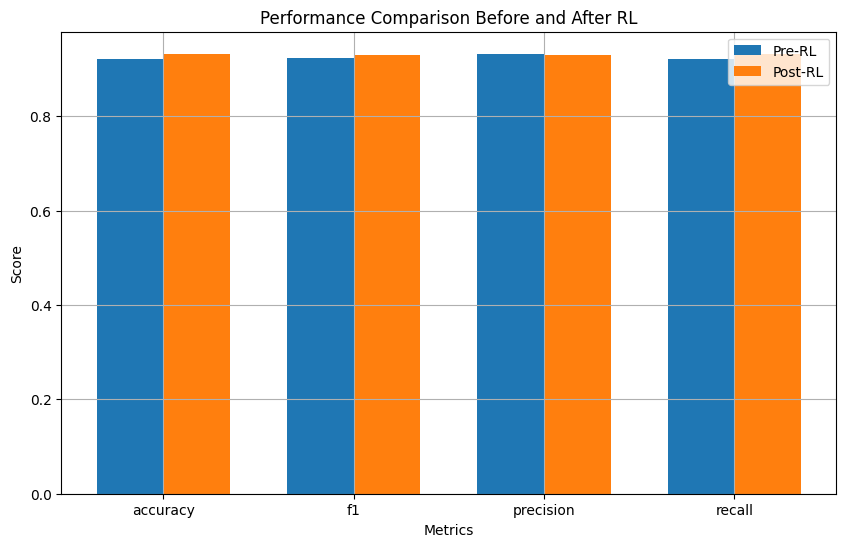

In [10]:
import numpy as np
import matplotlib.pyplot as plt

'''
print("\nEvaluating post-RL performance...")
post_rl_metrics = evaluate_model(model, test_dataloader, device)
print("Post-RL Test Metrics:", post_rl_metrics)
'''
#Plot confronto pre-post RL
def plot_pre_post_rl_comparison(pre_metrics, post_metrics):
    metrics_names = list(pre_metrics.keys())
    pre_values = [pre_metrics[name] for name in metrics_names]
    post_values = [post_metrics[name] for name in metrics_names]

    x = np.arange(len(metrics_names))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, pre_values, width, label='Pre-RL')
    plt.bar(x + width/2, post_values, width, label='Post-RL')

    plt.title('Performance Comparison Before and After RL')
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.xticks(x, metrics_names)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_pre_post_rl_comparison(pre_rl_metrics, post_rl_metrics)

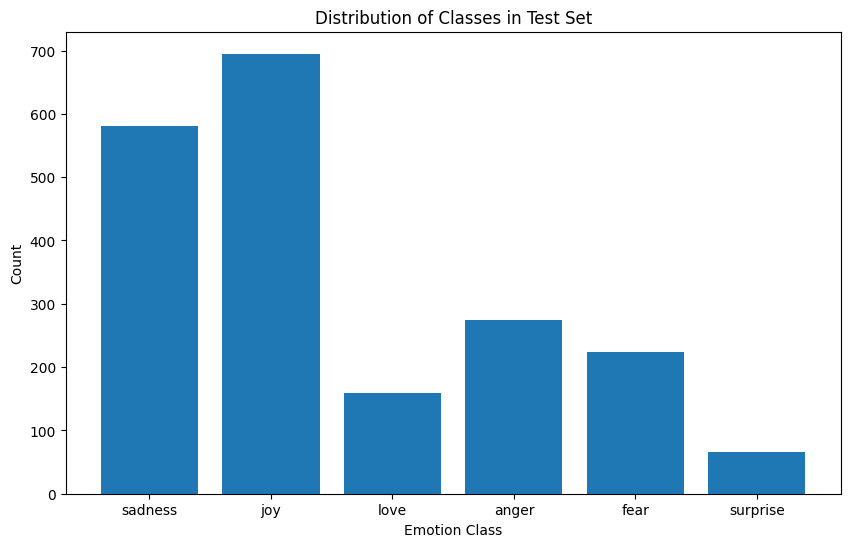

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


unique, counts = np.unique(all_test_labels, return_counts=True)
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts)
plt.title('Distribution of Classes in Test Set')
plt.xlabel('Emotion Class')
plt.ylabel('Count')
plt.show()

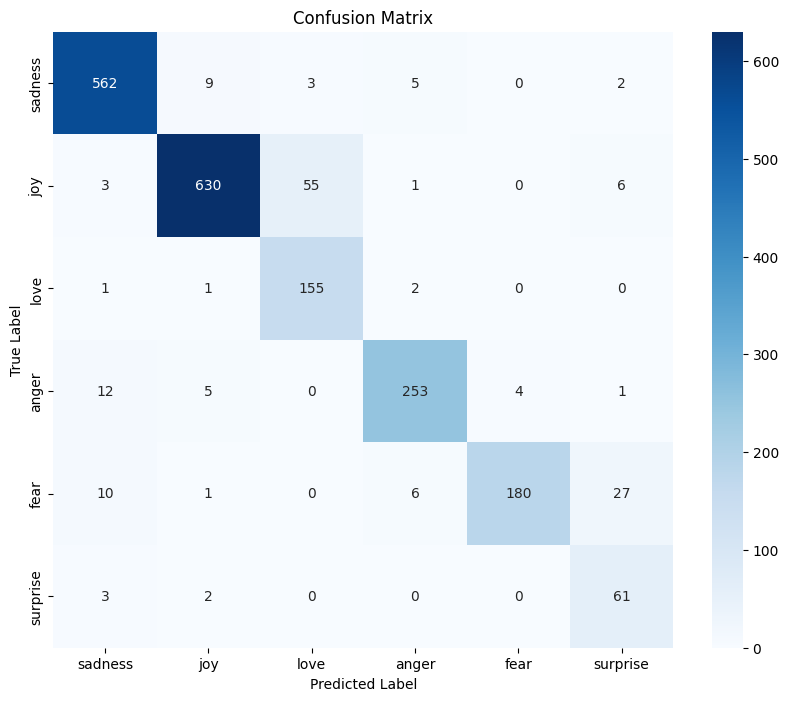

In [12]:

# Etichette delle classi (dataset emotion)
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()